# Data Analysis of voj demand data

In [43]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np

import h3
import folium

from shapely.geometry import Polygon
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex

In [44]:
# variables
INPUT_FILE_PATH = "../processed_data/voi_demand_h3.pickle"

In [45]:
df = pd.read_pickle(INPUT_FILE_PATH)
df = gpd.GeoDataFrame(df)
df.reset_index(inplace=True)
df.head()

,timestamp,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,grid_index,community_index
0,2025-02-11 14:57:35,VOJ:Vehicle:ed086d78-6194-4a8b-a37c-390f1f07533c,69600.0,None,pickup,POINT (9.23589 48.81528),881faa7181fffff,861faa71fffffff
1,2025-02-11 14:57:35,VOJ:Vehicle:e1b69fc3-bf67-4eb8-a091-f2bc178d2f8d,76000.0,None,pickup,POINT (9.15024 48.81025),881faa713dfffff,861faa717ffffff
2,2025-02-11 14:57:35,VOJ:Vehicle:f1339d7c-0637-4a19-957d-fab5a843bda0,59200.0,None,pickup,POINT (9.16081 48.77264),881faa7a8dfffff,861faa7afffffff
3,2025-02-11 14:57:35,VOJ:Vehicle:149ddb57-a0b6-4bd2-a77a-aebb2132abfd,51200.0,None,pickup,POINT (9.15595 48.81764),881faa7107fffff,861faa717ffffff
4,2025-02-11 14:57:35,VOJ:Vehicle:2030e8bd-f73f-454a-9065-c129a5ec6ca9,76000.0,None,pickup,POINT (9.10643 48.72325),881faa782bfffff,861faa787ffffff


## Temporal time bining

In [46]:
time_bins = [0, 5, 9, 13, 20]
time_labels = ["morning", "midday", "afternoon", "evening"]
df["time_bin"] = pd.cut(
    df["timestamp"].dt.hour, bins=time_bins, labels=time_labels, right=False
)

In [47]:
pickup_demand = df[df["event_type"] == "pickup"].copy()
dropoff_demand = df[df["event_type"] == "dropoff"].copy()
pickup_demand.drop(columns=["event_type"], inplace=True)
dropoff_demand.drop(columns=["event_type"], inplace=True)
len(pickup_demand), len(dropoff_demand)

(266581, 266771)

In [48]:
pickup_demand["grid_index"].nunique()

224

In [49]:
# display pickup demand as a heatmap based on the h3 index
def display_as_heatmap(temp_df):
    grid_counts = temp_df["grid_index"].value_counts().reset_index()
    grid_counts.columns = ["grid_index", "count"]

    grid_polygons = []
    for idx in grid_counts["grid_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in grid_polygons],
        crs="EPSG:4326",
    )

    # Calculate map boundaries
    bounds = grid_gdf.total_bounds  # [minx, miny, maxx, maxy]
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    # Create a non-interactive map
    m_pickup = folium.Map(
        location=[mean_lat_pickup, mean_lon_pickup],
        no_touch=True,
        dragging=False,
        zoom_control=False,
    )

    def get_color(count, max_count):
        norm = Normalize(vmin=0, vmax=max_count**0.9)
        colormap = cm.get_cmap("viridis")
        rgba_color = colormap(norm(count))
        return to_hex(rgba_color)

    max_count = grid_gdf["count"].max()

    # Add hexagons to map
    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row["count"]: {
                "fillColor": get_color(count, max_count),
                "color": "transparent",
                "weight": 1,
                "fillOpacity": 0.7,
            },
            tooltip=f"Count: {row['count']}, Grid Index: {row['grid_index']}",
        ).add_to(m_pickup)

    community_counts = temp_df["community_index"].value_counts().reset_index()
    community_counts.columns = ["community_index", "count"]
    community_counts["cell_count"] = temp_df.groupby("community_index")[
        "grid_index"
    ].transform("nunique")

    community_polygons = []
    for idx in community_counts["community_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        community_polygons.append(polygon_geojson)

    community_gdf = gpd.GeoDataFrame(
        community_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in community_polygons],
        crs="EPSG:4326",
    )

    # Add community polygons to map
    for idx, row in community_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x: {"color": "black", "weight": 1, "fillOpacity": 0},
            tooltip=f"Community Index : {row['community_index']}, Count: {row['count']}, Cell Count: {row['cell_count']}",
        ).add_to(m_pickup)

    # Fit map to bounds
    m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

    return m_pickup

In [50]:
display_as_heatmap(pickup_demand)

/tmp/ipykernel_2176832/1579897830.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")
/tmp/ipykernel_2176832/1579897830.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


In [51]:
display_as_heatmap(dropoff_demand)

/tmp/ipykernel_2176832/1579897830.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")
/tmp/ipykernel_2176832/1579897830.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


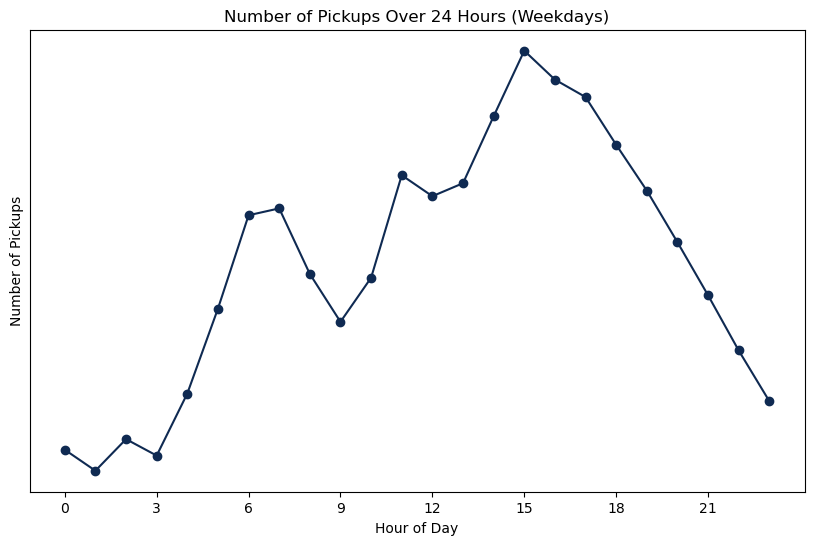

In [52]:
# Group by hour and count pickups
pickup_hourly_weekday = (
    pickup_demand[pickup_demand["timestamp"].dt.dayofweek < 5]["timestamp"]
    .dt.hour.value_counts()
    .sort_index()
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(
    pickup_hourly_weekday.index,
    pickup_hourly_weekday.values,
    marker="o",
    linestyle="-",
    color="#0F2A52",
)
plt.title("Number of Pickups Over 24 Hours (Weekdays)")
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.show()

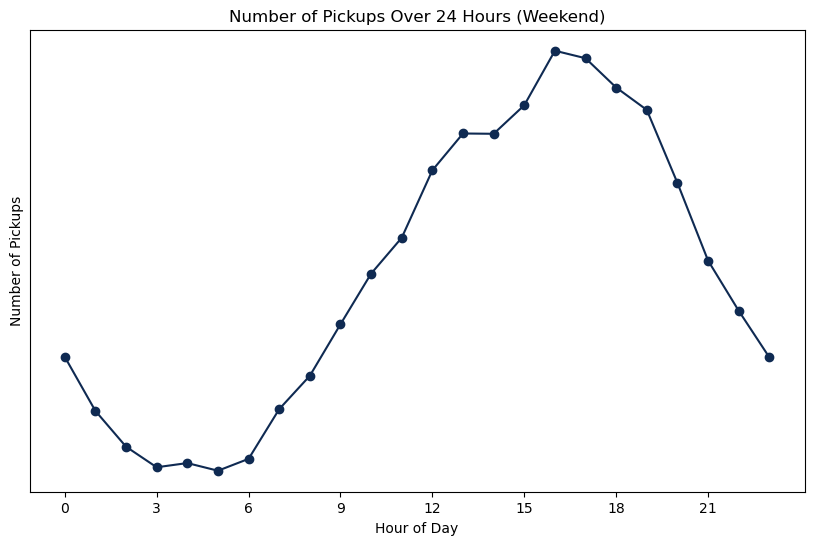

In [53]:
pickup_hourly_weekend = (
    pickup_demand[pickup_demand["timestamp"].dt.dayofweek >= 5]["timestamp"]
    .dt.hour.value_counts()
    .sort_index()
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(
    pickup_hourly_weekend.index,
    pickup_hourly_weekend.values,
    marker="o",
    linestyle="-",
    color="#0F2A52",
)
plt.title("Number of Pickups Over 24 Hours (Weekend)")
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.show()

In [54]:
# Aggregate data hourly and for each grid cell (pickups and dropoffs)
pickup_hourly = (
    pickup_demand.groupby([pickup_demand["timestamp"].dt.hour, "grid_index"])
    .size()
    .reset_index()
)
pickup_hourly.columns = ["hour", "grid_index", "pickup_count"]

dropoff_hourly = (
    dropoff_demand.groupby([dropoff_demand["timestamp"].dt.hour, "grid_index"])
    .size()
    .reset_index()
)
dropoff_hourly.columns = ["hour", "grid_index", "dropoff_count"]

rebalance_data = pd.merge(
    pickup_hourly, dropoff_hourly, on=["hour", "grid_index"], how="outer"
).fillna(0)
rebalance_data["imbalance"] = (
    rebalance_data["pickup_count"] - rebalance_data["dropoff_count"]
)

# Aggregate by hour
rebalance_data_aggregated = (
    rebalance_data.groupby("hour").agg({"imbalance": "sum"}).reset_index()
)

rebalance_data.head()

,hour,grid_index,pickup_count,dropoff_count,imbalance
0,0,881faa4485fffff,0.0,3.0,-3.0
1,0,881faa44b1fffff,6.0,16.0,-10.0
2,0,881faa44b3fffff,8.0,9.0,-1.0
3,0,881faa44bbfffff,0.0,1.0,-1.0
4,0,881faa6301fffff,10.0,4.0,6.0


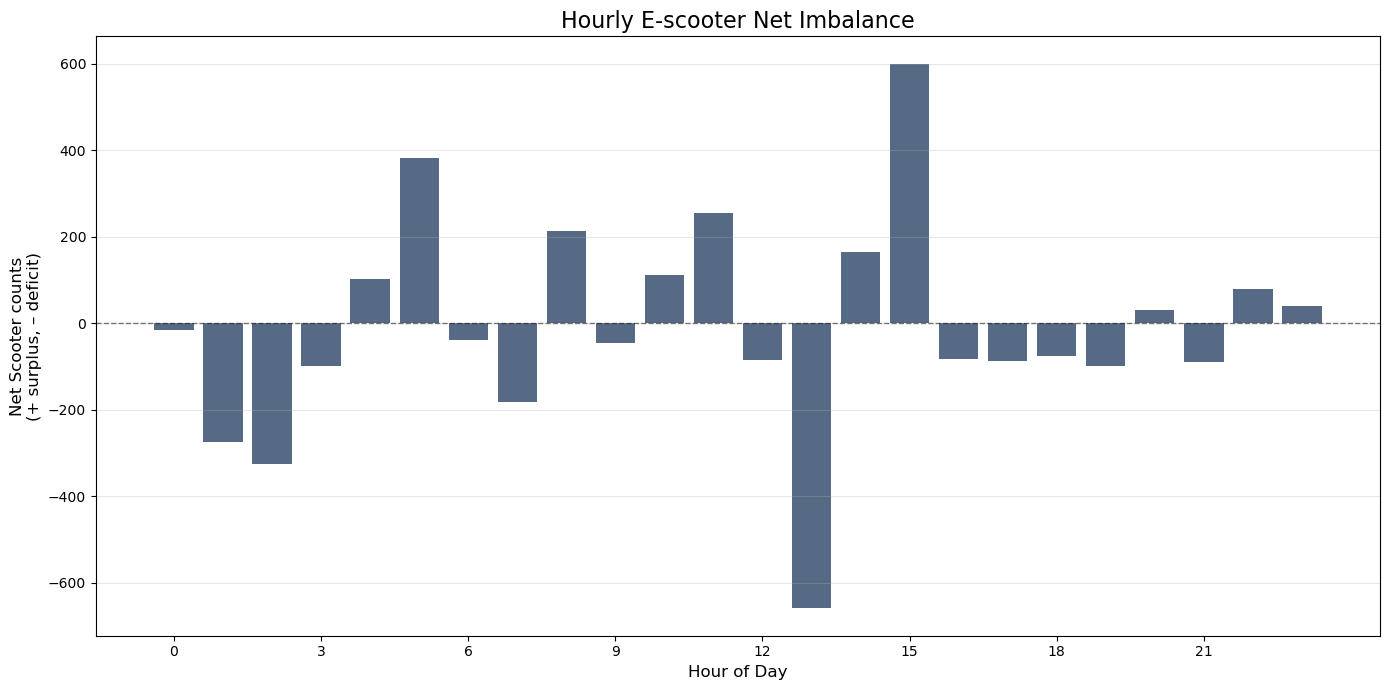

In [55]:
# Draw imbalance hourly
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(
    rebalance_data_aggregated["hour"],
    rebalance_data_aggregated["imbalance"],
    width=0.8,
    label="Net Imbalance (Pickups – Dropoffs)",
    color="#0F2A52",
    alpha=0.7,
)

ax.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.5)

ax.set_xlabel("Hour of Day", fontsize=12)
ax.set_ylabel("Net Scooter counts\n(+ surplus, – deficit)", fontsize=12)
ax.set_xticks(range(0, 24, 3))
ax.grid(axis="y", alpha=0.3)

plt.title("Hourly E-scooter Net Imbalance", fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
# display pickup demand as a heatmap based on the h3 index
import branca


def display_imbalance_as_heatmap(temp_df, rebalance_data):
    grid_counts = (
        rebalance_data.groupby("grid_index")["imbalance"].agg("sum").reset_index()
    )
    grid_counts.columns = ["grid_index", "imbalance"]

    grid_polygons = []
    for idx in grid_counts["grid_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in grid_polygons],
        crs="EPSG:4326",
    )

    bounds = grid_gdf.total_bounds  # [minx, miny, maxx, maxy]
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    m_pickup = folium.Map(
        location=[mean_lat_pickup, mean_lon_pickup], tiles="Cartodb Positron",
    )

    def get_color(count, max_abs):
        # red means deficit, blue means surplus
        cmap = branca.colormap.LinearColormap(
            colors=["blue", "white", "red"],
            vmin=-max_abs,
            vmax=+max_abs,
            caption="Net Imbalance (pickups – dropoffs)",
        ).to_step(10)
        rgba = cmap(count)
        return to_hex(rgba)

    max_abs = grid_gdf["imbalance"].abs().max()

    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row["imbalance"]: {
                "fillColor": get_color(count, max_abs),
                "color": "transparent",
                "weight": 1,
                "fillOpacity": 0.7,
            },
            tooltip=f"Imbalance: {row['imbalance']}, Grid Index: {row['grid_index']}",
        ).add_to(m_pickup)

    # m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    m_pickup.location = [mean_lat_pickup, mean_lon_pickup]
    m_pickup.

    return m_pickup

SyntaxError: invalid syntax (3864064666.py, line 57)

# Draw imbalance on a map
Red cells are areas where more pick-up events happen than drop-offs

## Imbalance in the morning peak

In [ ]:
display_imbalance_as_heatmap(
    pickup_demand,
    rebalance_data[(rebalance_data["hour"] >= 3) & (rebalance_data["hour"] < 8)],
)

## Imbalance at evening peak

In [ ]:
display_imbalance_as_heatmap(
    pickup_demand,
    rebalance_data[(rebalance_data["hour"] >= 15) & (rebalance_data["hour"] < 20)],
)